In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm


In [2]:
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise
    return series[..., np.newaxis].astype(np.float32)

In [3]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 1)
x_train, y_train = series[:7000, :n_steps], series[:7000, -1]
x_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
x_test, y_test = series[9000:, :n_steps], series[9000:, -1]

In [4]:
x_train = torch.from_numpy(x_train.astype(np.float32))
x_test = torch.from_numpy(x_test.astype(np.float32))
y_train = torch.from_numpy(y_train.reshape(-1,1).astype(np.float32))
y_test = torch.from_numpy(y_test.reshape(-1,1).astype(np.float32))

In [5]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

(torch.Size([7000, 50, 1]),
 torch.Size([7000, 1]),
 torch.Size([1000, 50, 1]),
 torch.Size([1000, 1]))

In [6]:
train_dataset = torch.utils.data.TensorDataset(x_train, y_train)
test_dataset = torch.utils.data.TensorDataset(x_test, y_test)

In [7]:
batch_size = 32 # The default in Keras
train_loader = torch.utils.data.DataLoader(
                        dataset=train_dataset,
                        batch_size=batch_size,
                        shuffle=False
                        )


test_loader = torch.utils.data.DataLoader(
                        dataset=test_dataset,
                        batch_size=batch_size,
                        shuffle=False # Not necessary!
                        )

In [8]:
model_dense = nn.Sequential(
                    nn.Flatten(),
                    nn.Linear(50,1)
                    )

In [9]:
from torchsummary import summary
summary(model_dense, (50,1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                   [-1, 50]               0
            Linear-2                    [-1, 1]              51
Total params: 51
Trainable params: 51
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [13]:
class PyTorchTrainer_Reg(object):
    def __init__(self,
                model,
                optim,
                loss_fn,
                device="cpu"):
        self.model = model
        self.optim = optim
        self.loss_fn = loss_fn
        self.device = device
        
    def fit(self,
            train_loader,
            test_loader,
            n_epochs: int=100,
            eval_inter: int=1):
        history = {}
        history['epoch'] = []
        history['training_loss'] = []
        history['test_loss'] = []
        
        # Training Loop

        history['p_test'] = []
        history['x_test'] = test_loader.dataset[:][0]
        history['y_test'] = test_loader.dataset[:][1]
        p_test = np.array([]) # for listing all predictions - last epoch only

        for epoch in range(n_epochs):
            history['epoch'].append(epoch+1)
            self.model.train()
            train_loss = []
            
            for inputs, targets in tqdm(train_loader, leave=False):
                # Move data to GPU
                inputs, targets = inputs.to(self.device), targets.to(self.device)

                # zero the gradient
                self.optim.zero_grad()

                # forward pass
                outputs = self.model(inputs)
                loss = self.loss_fn(outputs, targets)

                # backward pass and optimize
                loss.backward()
                self.optim.step()

                train_loss.append(loss.item())

            train_loss = np.mean(train_loss)
            
            # save losses
            history['training_loss'].append(train_loss) 
    
            test_loss = []
            
            self.model.eval()
            with torch.no_grad():
                for inputs, targets in test_loader:
                    # Move data to GPU
                    inputs, targets = inputs.to(self.device), targets.to(self.device)

                    # forward pass
                    outputs_test = self.model(inputs)
                    loss_test = self.loss_fn(outputs_test, targets)

                    # update list of predictions  - done for last epoch only!
                    if epoch == (n_epochs - 1):
                        history['p_test'] = outputs_test.numpy()


                    test_loss.append(loss_test.item())
            history['p_test'] = p_test
            test_loss = np.mean(test_loss)
            # save losses
            history['test_loss'].append(test_loss) 
            
            if (epoch +1) % eval_inter == 0:
                print(f"Epoch: {epoch+1}/{n_epochs}, Train Loss: {history['training_loss'][-1]:.4f}, Test Loss: {history['test_loss'][-1]:.4f}", end='')
        return history
                
            

In [11]:
# If GPU...
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model_dense.to(device)

cpu


Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=50, out_features=1, bias=True)
)

In [12]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model_dense.parameters(), eps=1e-07)

In [13]:
trainer = PyTorchTrainer_Reg(model_dense, optimizer, loss_fn,device)
history={}
history = trainer.fit(train_loader,test_loader,20,1)

  0%|          | 0/219 [00:00<?, ?it/s]

Epoch: 1/20, Train Loss: 0.0455, Test Loss: 0.0217

  0%|          | 0/219 [00:00<?, ?it/s]

Epoch: 2/20, Train Loss: 0.0169, Test Loss: 0.0139

  0%|          | 0/219 [00:00<?, ?it/s]

Epoch: 3/20, Train Loss: 0.0118, Test Loss: 0.0108

  0%|          | 0/219 [00:00<?, ?it/s]

Epoch: 4/20, Train Loss: 0.0095, Test Loss: 0.0090

  0%|          | 0/219 [00:00<?, ?it/s]

Epoch: 5/20, Train Loss: 0.0080, Test Loss: 0.0075

  0%|          | 0/219 [00:00<?, ?it/s]

Epoch: 6/20, Train Loss: 0.0068, Test Loss: 0.0064

  0%|          | 0/219 [00:00<?, ?it/s]

Epoch: 7/20, Train Loss: 0.0059, Test Loss: 0.0056

  0%|          | 0/219 [00:00<?, ?it/s]

Epoch: 8/20, Train Loss: 0.0052, Test Loss: 0.0050

  0%|          | 0/219 [00:00<?, ?it/s]

Epoch: 9/20, Train Loss: 0.0047, Test Loss: 0.0046

  0%|          | 0/219 [00:00<?, ?it/s]

Epoch: 10/20, Train Loss: 0.0044, Test Loss: 0.0043

  0%|          | 0/219 [00:00<?, ?it/s]

Epoch: 11/20, Train Loss: 0.0041, Test Loss: 0.0040

  0%|          | 0/219 [00:00<?, ?it/s]

Epoch: 12/20, Train Loss: 0.0040, Test Loss: 0.0039

  0%|          | 0/219 [00:00<?, ?it/s]

Epoch: 13/20, Train Loss: 0.0038, Test Loss: 0.0037

  0%|          | 0/219 [00:00<?, ?it/s]

Epoch: 14/20, Train Loss: 0.0037, Test Loss: 0.0036

  0%|          | 0/219 [00:00<?, ?it/s]

Epoch: 15/20, Train Loss: 0.0037, Test Loss: 0.0036

  0%|          | 0/219 [00:00<?, ?it/s]

Epoch: 16/20, Train Loss: 0.0036, Test Loss: 0.0035

  0%|          | 0/219 [00:00<?, ?it/s]

Epoch: 17/20, Train Loss: 0.0035, Test Loss: 0.0034

  0%|          | 0/219 [00:00<?, ?it/s]

Epoch: 18/20, Train Loss: 0.0035, Test Loss: 0.0034

  0%|          | 0/219 [00:00<?, ?it/s]

Epoch: 19/20, Train Loss: 0.0034, Test Loss: 0.0033

  0%|          | 0/219 [00:00<?, ?it/s]

Epoch: 20/20, Train Loss: 0.0034, Test Loss: 0.0033

In [ ]:
h0 = torch.zeros( , , , ).to(device)
model_rnn = nn.Sequential(
                    nn.Flatten(),
                    nn.Linear(50,1)
                    )

In [36]:
class SimpleRNN(nn.Module):
    def __init__(self, n_features, n_hidden, n_rnnlayers):
        super(SimpleRNN, self).__init__()
        self.F = n_features
        self.H = n_hidden
        self.N = n_rnnlayers
        self.rnn = nn.RNN(input_size=self.F,
                         hidden_size=self.H,
                         num_layers=self.N,
                         nonlinearity='tanh',
                         batch_first=True
                         )
# #         self.fc = nn.Linear(1, 1)
    def forward(self,X):
        h0 = torch.zeros(self.N, X.size(0), self.H).to(device)
        out, _ = self.rnn(X, h0)
#         out = self.fc(out[:,-1, :])
        out = out[:,-1, :]
        return out
        

In [37]:
model_sr = SimpleRNN(1, 1, 1)

from torchsummary import summary
summary(model_sr, (50,1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
               RNN-1  [[-1, 50, 1], [-1, 2, 1]]               0


AttributeError: 'int' object has no attribute 'numpy'

In [38]:
print(model_sr)

SimpleRNN(
  (rnn): RNN(1, 1, batch_first=True)
)


In [39]:
# If GPU...
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model_sr.to(device)

cpu


SimpleRNN(
  (rnn): RNN(1, 1, batch_first=True)
)

In [40]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model_sr.parameters(), lr=0.005, eps=1e-07)

In [41]:
trainer = PyTorchTrainer_Reg(model_sr, optimizer, loss_fn,device)
history={}
history = trainer.fit(train_loader,test_loader,20,1)

  0%|          | 0/219 [00:00<?, ?it/s]

Epoch: 1/20, Train Loss: 0.3931, Test Loss: 0.0942

  0%|          | 0/219 [00:00<?, ?it/s]

Epoch: 2/20, Train Loss: 0.0471, Test Loss: 0.0291

  0%|          | 0/219 [00:00<?, ?it/s]

Epoch: 3/20, Train Loss: 0.0249, Test Loss: 0.0230

  0%|          | 0/219 [00:00<?, ?it/s]

Epoch: 4/20, Train Loss: 0.0203, Test Loss: 0.0193

  0%|          | 0/219 [00:00<?, ?it/s]

Epoch: 5/20, Train Loss: 0.0173, Test Loss: 0.0167

  0%|          | 0/219 [00:00<?, ?it/s]

Epoch: 6/20, Train Loss: 0.0153, Test Loss: 0.0149

  0%|          | 0/219 [00:00<?, ?it/s]

Epoch: 7/20, Train Loss: 0.0138, Test Loss: 0.0136

  0%|          | 0/219 [00:00<?, ?it/s]

Epoch: 8/20, Train Loss: 0.0129, Test Loss: 0.0127

  0%|          | 0/219 [00:00<?, ?it/s]

Epoch: 9/20, Train Loss: 0.0122, Test Loss: 0.0121

  0%|          | 0/219 [00:00<?, ?it/s]

Epoch: 10/20, Train Loss: 0.0118, Test Loss: 0.0117

  0%|          | 0/219 [00:00<?, ?it/s]

Epoch: 11/20, Train Loss: 0.0116, Test Loss: 0.0115

  0%|          | 0/219 [00:00<?, ?it/s]

Epoch: 12/20, Train Loss: 0.0115, Test Loss: 0.0113

  0%|          | 0/219 [00:00<?, ?it/s]

Epoch: 13/20, Train Loss: 0.0114, Test Loss: 0.0113

  0%|          | 0/219 [00:00<?, ?it/s]

Epoch: 14/20, Train Loss: 0.0114, Test Loss: 0.0113

  0%|          | 0/219 [00:00<?, ?it/s]

Epoch: 15/20, Train Loss: 0.0114, Test Loss: 0.0112

  0%|          | 0/219 [00:00<?, ?it/s]

Epoch: 16/20, Train Loss: 0.0114, Test Loss: 0.0112

  0%|          | 0/219 [00:00<?, ?it/s]

Epoch: 17/20, Train Loss: 0.0114, Test Loss: 0.0112

  0%|          | 0/219 [00:00<?, ?it/s]

Epoch: 18/20, Train Loss: 0.0114, Test Loss: 0.0112

  0%|          | 0/219 [00:00<?, ?it/s]

Epoch: 19/20, Train Loss: 0.0114, Test Loss: 0.0112

  0%|          | 0/219 [00:00<?, ?it/s]

Epoch: 20/20, Train Loss: 0.0114, Test Loss: 0.0112

worse than Dense NN!

In [59]:
class DeepRNN(nn.Module):
    def __init__(self, n_features, n_hidden, n_rnnlayers):
        super(DeepRNN, self).__init__()
        self.F = n_features
        self.H = n_hidden
        self.N = n_rnnlayers
        self.rnn1 = nn.RNN(input_size=self.F,
                         hidden_size=self.H,
                         num_layers=self.N,
                         nonlinearity='tanh',
                         batch_first=True
                         )
        self.rnn2 = nn.RNN(input_size=self.H,
                         hidden_size=self.H,
                         num_layers=self.N,
                         nonlinearity='tanh',
                         batch_first=True
                         )
        self.rnn3 = nn.RNN(input_size=self.H,
                         hidden_size=1,
                         num_layers=self.N,
                         nonlinearity='tanh',
                         batch_first=True
                         )
#         self.fc = nn.Linear(1, 1)
    def forward(self,X):
#         h0 = torch.zeros(self.N, X.size(0), self.H).to(device)
        out, _ = self.rnn1(X)
#         print(out.shape)
#         out = out[:,-1, :]
#         print(out.shape)
        out, _ = self.rnn2(out)
#         out = out[:,-1, :]
        out, _ = self.rnn3(out)
        out = out[:,-1, :]
#         out = self.fc(out[:,-1, :])
        return out
        

In [60]:
model_dr = DeepRNN(1, 20, 1)

from torchsummary import summary
summary(model_dr, (50,1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
               RNN-1  [[-1, 50, 20], [-1, 2, 20]]               0
               RNN-2  [[-1, 50, 20], [-1, 2, 20]]               0
               RNN-3  [[-1, 50, 1], [-1, 2, 1]]               0


AttributeError: 'int' object has no attribute 'numpy'

In [61]:
print(model_dr)

DeepRNN(
  (rnn1): RNN(1, 20, batch_first=True)
  (rnn2): RNN(20, 20, batch_first=True)
  (rnn3): RNN(20, 1, batch_first=True)
)


In [62]:
# If GPU...
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model_dr.to(device)

cpu


DeepRNN(
  (rnn1): RNN(1, 20, batch_first=True)
  (rnn2): RNN(20, 20, batch_first=True)
  (rnn3): RNN(20, 1, batch_first=True)
)

In [63]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model_dr.parameters(), eps=1e-07)

In [64]:
trainer = PyTorchTrainer_Reg(model_dr, optimizer, loss_fn,device)
history={}
history = trainer.fit(train_loader,test_loader,20,1)

  0%|          | 0/219 [00:00<?, ?it/s]

Epoch: 1/20, Train Loss: 0.0314, Test Loss: 0.0059

  0%|          | 0/219 [00:00<?, ?it/s]

Epoch: 2/20, Train Loss: 0.0050, Test Loss: 0.0055

  0%|          | 0/219 [00:00<?, ?it/s]

Epoch: 3/20, Train Loss: 0.0045, Test Loss: 0.0049

  0%|          | 0/219 [00:00<?, ?it/s]

Epoch: 4/20, Train Loss: 0.0042, Test Loss: 0.0046

  0%|          | 0/219 [00:00<?, ?it/s]

Epoch: 5/20, Train Loss: 0.0041, Test Loss: 0.0045

  0%|          | 0/219 [00:00<?, ?it/s]

Epoch: 6/20, Train Loss: 0.0040, Test Loss: 0.0045

  0%|          | 0/219 [00:00<?, ?it/s]

Epoch: 7/20, Train Loss: 0.0040, Test Loss: 0.0045

  0%|          | 0/219 [00:00<?, ?it/s]

Epoch: 8/20, Train Loss: 0.0040, Test Loss: 0.0044

  0%|          | 0/219 [00:00<?, ?it/s]

Epoch: 9/20, Train Loss: 0.0039, Test Loss: 0.0042

  0%|          | 0/219 [00:00<?, ?it/s]

Epoch: 10/20, Train Loss: 0.0038, Test Loss: 0.0041

  0%|          | 0/219 [00:00<?, ?it/s]

Epoch: 11/20, Train Loss: 0.0037, Test Loss: 0.0043

  0%|          | 0/219 [00:00<?, ?it/s]

Epoch: 12/20, Train Loss: 0.0037, Test Loss: 0.0044

  0%|          | 0/219 [00:00<?, ?it/s]

Epoch: 13/20, Train Loss: 0.0037, Test Loss: 0.0043

  0%|          | 0/219 [00:00<?, ?it/s]

Epoch: 14/20, Train Loss: 0.0037, Test Loss: 0.0043

  0%|          | 0/219 [00:00<?, ?it/s]

Epoch: 15/20, Train Loss: 0.0037, Test Loss: 0.0042

  0%|          | 0/219 [00:00<?, ?it/s]

Epoch: 16/20, Train Loss: 0.0036, Test Loss: 0.0041

  0%|          | 0/219 [00:00<?, ?it/s]

Epoch: 17/20, Train Loss: 0.0036, Test Loss: 0.0041

  0%|          | 0/219 [00:00<?, ?it/s]

Epoch: 18/20, Train Loss: 0.0036, Test Loss: 0.0040

  0%|          | 0/219 [00:00<?, ?it/s]

Epoch: 19/20, Train Loss: 0.0036, Test Loss: 0.0040

  0%|          | 0/219 [00:00<?, ?it/s]

Epoch: 20/20, Train Loss: 0.0035, Test Loss: 0.0040

In [8]:
class DeepRNN_D(nn.Module):
    def __init__(self, n_features, n_hidden, n_rnnlayers):
        super(DeepRNN_D, self).__init__()
        self.F = n_features
        self.H = n_hidden
        self.N = n_rnnlayers
        self.rnn1 = nn.RNN(input_size=self.F,
                         hidden_size=self.H,
                         num_layers=self.N,
                         nonlinearity='tanh',
                         batch_first=True
                         )
        self.rnn2 = nn.RNN(input_size=self.H,
                         hidden_size=self.H,
                         num_layers=self.N,
                         nonlinearity='tanh',
                         batch_first=True
                         )
        self.linear1 = nn.Linear(20,1)
#         self.fc = nn.Linear(1, 1)
    def forward(self,X):
#         h0 = torch.zeros(self.N, X.size(0), self.H).to(device)
        out, _ = self.rnn1(X)
#         print(out.shape)
#         out = out[:,-1, :]
#         print(out.shape)
        out, _ = self.rnn2(out)
#         out = out[:,-1, :]
        out= self.linear1(out)
        out = out[:,-1, :]
#         out = self.fc(out[:,-1, :])
        return out
        

In [9]:
model_dr2 = DeepRNN_D(1, 20, 1)

from torchsummary import summary
summary(model_dr2, (50,1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
               RNN-1  [[-1, 50, 20], [-1, 2, 20]]               0
               RNN-2  [[-1, 50, 20], [-1, 2, 20]]               0
            Linear-3                [-1, 50, 1]              21
Total params: 21
Trainable params: 21
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.61
Params size (MB): 0.00
Estimated Total Size (MB): 0.61
----------------------------------------------------------------


In [10]:
# If GPU...
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model_dr2.to(device)

cpu


DeepRNN_D(
  (rnn1): RNN(1, 20, batch_first=True)
  (rnn2): RNN(20, 20, batch_first=True)
  (linear1): Linear(in_features=20, out_features=1, bias=True)
)

In [11]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model_dr2.parameters(), eps=1e-07)

In [14]:
trainer = PyTorchTrainer_Reg(model_dr2, optimizer, loss_fn,device)
history={}
history = trainer.fit(train_loader,test_loader,20,1)

  0%|          | 0/219 [00:00<?, ?it/s]

Epoch: 1/20, Train Loss: 0.0363, Test Loss: 0.0063

  0%|          | 0/219 [00:00<?, ?it/s]

Epoch: 2/20, Train Loss: 0.0052, Test Loss: 0.0051

  0%|          | 0/219 [00:00<?, ?it/s]

Epoch: 3/20, Train Loss: 0.0043, Test Loss: 0.0045

  0%|          | 0/219 [00:00<?, ?it/s]

Epoch: 4/20, Train Loss: 0.0039, Test Loss: 0.0044

  0%|          | 0/219 [00:00<?, ?it/s]

Epoch: 5/20, Train Loss: 0.0037, Test Loss: 0.0043

  0%|          | 0/219 [00:00<?, ?it/s]

Epoch: 6/20, Train Loss: 0.0036, Test Loss: 0.0043

  0%|          | 0/219 [00:00<?, ?it/s]

Epoch: 7/20, Train Loss: 0.0035, Test Loss: 0.0045

  0%|          | 0/219 [00:00<?, ?it/s]

Epoch: 8/20, Train Loss: 0.0035, Test Loss: 0.0045

  0%|          | 0/219 [00:00<?, ?it/s]

Epoch: 9/20, Train Loss: 0.0035, Test Loss: 0.0045

  0%|          | 0/219 [00:00<?, ?it/s]

Epoch: 10/20, Train Loss: 0.0035, Test Loss: 0.0045

  0%|          | 0/219 [00:00<?, ?it/s]

Epoch: 11/20, Train Loss: 0.0035, Test Loss: 0.0044

  0%|          | 0/219 [00:00<?, ?it/s]

Epoch: 12/20, Train Loss: 0.0034, Test Loss: 0.0045

  0%|          | 0/219 [00:00<?, ?it/s]

Epoch: 13/20, Train Loss: 0.0034, Test Loss: 0.0045

  0%|          | 0/219 [00:00<?, ?it/s]

Epoch: 14/20, Train Loss: 0.0034, Test Loss: 0.0045

  0%|          | 0/219 [00:00<?, ?it/s]

Epoch: 15/20, Train Loss: 0.0034, Test Loss: 0.0045

  0%|          | 0/219 [00:00<?, ?it/s]

Epoch: 16/20, Train Loss: 0.0033, Test Loss: 0.0045

  0%|          | 0/219 [00:00<?, ?it/s]

Epoch: 17/20, Train Loss: 0.0033, Test Loss: 0.0046

  0%|          | 0/219 [00:00<?, ?it/s]

Epoch: 18/20, Train Loss: 0.0033, Test Loss: 0.0046

  0%|          | 0/219 [00:00<?, ?it/s]

Epoch: 19/20, Train Loss: 0.0033, Test Loss: 0.0045

  0%|          | 0/219 [00:00<?, ?it/s]

Epoch: 20/20, Train Loss: 0.0033, Test Loss: 0.0045

# Forecasting several steps ahead

Two Options  
(1) use above model; run model several times  
(2) modify the model above to have more 'neurons' in the last layer (need to change the dataset as well)

## (1) use above model; run model several times

Generate series with 60 values; for 10 times, we will run it with 50 values as input and 1 as output. Also, for now, just one series is being generated.

In [22]:
np.random.seed(43) # not 42, as it would give the first series in the train set

series = generate_time_series(1, n_steps + 10)
X_new, Y_new = series[:, :n_steps], series[:, n_steps:]
X = X_new
X = torch.from_numpy(X.astype(np.float32))

for step_ahead in range(10):
#     y_pred_one = model_dr2(X[:, step_ahead:])
    y_pred_one = model_dr2(X[:, step_ahead:])[:, np.newaxis, :]
#     X = np.concatenate([X, y_pred_one], axis=1)
    X = torch.cat((X, y_pred_one), 1)
    

Y_pred = X[:, n_steps:]

<class 'numpy.ndarray'> (1, 50, 1)


In [30]:
Y_pred = Y_pred.cpu().detach().numpy()

In [25]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$"):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bx", markersize=10)
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "ro")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])

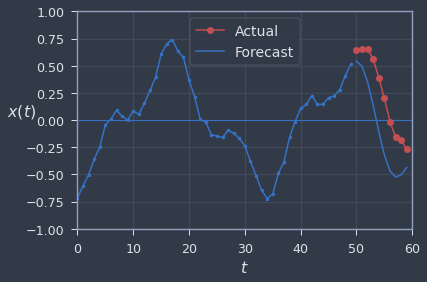

In [31]:
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "ro-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "bx-", label="Forecast", markersize=10)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)

plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

Now, lets generate the entire train/valid/test set (for 60 samples - 50 input/10 output) and 10000 samples

In [43]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train, Y_train = series[:7000, :n_steps], series[:7000, -10:, 0]
X_valid, Y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]
X_test, Y_test = series[9000:, :n_steps], series[9000:, -10:, 0]

In [33]:
X_train.shape, Y_train.shape

((7000, 50, 1), (7000, 10))

In [34]:
X = X_valid
X = torch.from_numpy(X.astype(np.float32))
for step_ahead in range(10):
    y_pred_one = model_dr2(X[:, step_ahead:])[:, np.newaxis, :]
    X = torch.cat((X, y_pred_one), 1)

Y_pred = X[:, n_steps:, 0]

In [35]:
Y_pred.shape

torch.Size([2000, 10])

In [38]:
Y_valid, Y_pred

(array([[-0.26987407, -0.17164926, -0.0988849 , ...,  0.5669505 ,
          0.5688474 ,  0.41949147],
        [-0.02512118, -0.08002812, -0.12266719, ..., -0.68340075,
         -0.63207376, -0.50682896],
        [-0.33793518, -0.37067884, -0.3432969 , ...,  0.531539  ,
          0.67162573,  0.6546509 ],
        ...,
        [ 0.42275637,  0.51365906,  0.46187153, ..., -0.07216047,
         -0.24438894, -0.27834383],
        [ 0.6016183 ,  0.614862  ,  0.65488905, ..., -0.05819283,
         -0.18601483, -0.25964588],
        [-0.26371443, -0.27332363, -0.27588886, ...,  0.25835633,
          0.4734089 ,  0.64015645]], dtype=float32),
 tensor([[-0.1417,  0.0096,  0.2077,  ...,  0.4131,  0.2890,  0.1901],
         [-0.1394, -0.2211, -0.3514,  ..., -0.3761, -0.1389,  0.0915],
         [-0.3550, -0.3733, -0.3560,  ...,  0.3637,  0.3977,  0.3580],
         ...,
         [ 0.4497,  0.4436,  0.3527,  ..., -0.3970, -0.4050, -0.3435],
         [ 0.5606,  0.4945,  0.3473,  ..., -0.4985, -0.4977,

## (2) modify the model above to have more 'neurons' in the last layer 

We need to recreate the dataset

In [44]:
X_train = torch.from_numpy(X_train.astype(np.float32))
X_test = torch.from_numpy(X_test.astype(np.float32))
Y_train = torch.from_numpy(Y_train.reshape(-1,10).astype(np.float32))
Y_test = torch.from_numpy(Y_test.reshape(-1,10).astype(np.float32))

In [45]:
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

(torch.Size([7000, 50, 1]),
 torch.Size([7000, 10]),
 torch.Size([1000, 50, 1]),
 torch.Size([1000, 10]))

In [46]:
train_dataset = torch.utils.data.TensorDataset(X_train, Y_train)
test_dataset = torch.utils.data.TensorDataset(X_test, Y_test)

In [47]:
batch_size = 32 # The default in Keras
train_loader = torch.utils.data.DataLoader(
                        dataset=train_dataset,
                        batch_size=batch_size,
                        shuffle=False
                        )


test_loader = torch.utils.data.DataLoader(
                        dataset=test_dataset,
                        batch_size=batch_size,
                        shuffle=False # Not necessary!
                        )

In [48]:
class DeepRNN_D10(nn.Module):
    def __init__(self, n_features, n_hidden, n_rnnlayers):
        super(DeepRNN_D10, self).__init__()
        self.F = n_features
        self.H = n_hidden
        self.N = n_rnnlayers
        self.rnn1 = nn.RNN(input_size=self.F,
                         hidden_size=self.H,
                         num_layers=self.N,
                         nonlinearity='tanh',
                         batch_first=True
                         )
        self.rnn2 = nn.RNN(input_size=self.H,
                         hidden_size=self.H,
                         num_layers=self.N,
                         nonlinearity='tanh',
                         batch_first=True
                         )
        self.linear1 = nn.Linear(20,10)

    def forward(self,X):
        out, _ = self.rnn1(X)
        out, _ = self.rnn2(out)
        out= self.linear1(out)
        out = out[:,-1, :]
        return out
        

In [50]:
model_dr10 = DeepRNN_D10(1, 20, 1)

from torchsummary import summary
summary(model_dr10, (50,1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
               RNN-1  [[-1, 50, 20], [-1, 2, 20]]               0
               RNN-2  [[-1, 50, 20], [-1, 2, 20]]               0
            Linear-3               [-1, 50, 10]             210
Total params: 210
Trainable params: 210
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.61
Params size (MB): 0.00
Estimated Total Size (MB): 0.61
----------------------------------------------------------------


In [51]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model_dr10.parameters(), eps=1e-07)

In [52]:
trainer = PyTorchTrainer_Reg(model_dr10, optimizer, loss_fn,device)
history={}
history = trainer.fit(train_loader,test_loader,20,1)

  0%|          | 0/219 [00:00<?, ?it/s]

Epoch: 1/20, Train Loss: 0.0714, Test Loss: 0.0486

  0%|          | 0/219 [00:00<?, ?it/s]

Epoch: 2/20, Train Loss: 0.0400, Test Loss: 0.0369

  0%|          | 0/219 [00:00<?, ?it/s]

Epoch: 3/20, Train Loss: 0.0331, Test Loss: 0.0287

  0%|          | 0/219 [00:00<?, ?it/s]

Epoch: 4/20, Train Loss: 0.0303, Test Loss: 0.0276

  0%|          | 0/219 [00:00<?, ?it/s]

Epoch: 5/20, Train Loss: 0.0291, Test Loss: 0.0263

  0%|          | 0/219 [00:00<?, ?it/s]

Epoch: 6/20, Train Loss: 0.0282, Test Loss: 0.0263

  0%|          | 0/219 [00:00<?, ?it/s]

Epoch: 7/20, Train Loss: 0.0273, Test Loss: 0.0261

  0%|          | 0/219 [00:00<?, ?it/s]

Epoch: 8/20, Train Loss: 0.0264, Test Loss: 0.0253

  0%|          | 0/219 [00:00<?, ?it/s]

Epoch: 9/20, Train Loss: 0.0253, Test Loss: 0.0228

  0%|          | 0/219 [00:00<?, ?it/s]

Epoch: 10/20, Train Loss: 0.0210, Test Loss: 0.0163

  0%|          | 0/219 [00:00<?, ?it/s]

Epoch: 11/20, Train Loss: 0.0182, Test Loss: 0.0158

  0%|          | 0/219 [00:00<?, ?it/s]

Epoch: 12/20, Train Loss: 0.0162, Test Loss: 0.0161

  0%|          | 0/219 [00:00<?, ?it/s]

Epoch: 13/20, Train Loss: 0.0157, Test Loss: 0.0133

  0%|          | 0/219 [00:00<?, ?it/s]

Epoch: 14/20, Train Loss: 0.0148, Test Loss: 0.0139

  0%|          | 0/219 [00:00<?, ?it/s]

Epoch: 15/20, Train Loss: 0.0146, Test Loss: 0.0123

  0%|          | 0/219 [00:00<?, ?it/s]

Epoch: 16/20, Train Loss: 0.0139, Test Loss: 0.0114

  0%|          | 0/219 [00:00<?, ?it/s]

Epoch: 17/20, Train Loss: 0.0135, Test Loss: 0.0111

  0%|          | 0/219 [00:00<?, ?it/s]

Epoch: 18/20, Train Loss: 0.0130, Test Loss: 0.0110

  0%|          | 0/219 [00:00<?, ?it/s]

Epoch: 19/20, Train Loss: 0.0130, Test Loss: 0.0105

  0%|          | 0/219 [00:00<?, ?it/s]

Epoch: 20/20, Train Loss: 0.0129, Test Loss: 0.0123